<a href="https://colab.research.google.com/github/tsangh/autobcc/blob/master/PutAllTogether.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*** Let's start

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

Create device-agnostic code

In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
print (f'Using device: {device}')

Using device: cpu


###　Ｄata
## create data using liner regresson formula
y = ax + b

In [4]:
weights = 0.7
bias = 0.3

#data range
start = 0
end = 1
step = 0.02

#create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weights * X + bias



In [5]:
#Split data for training,
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test= X[train_split:], y[train_split:]


In [6]:
#take a look at the first 10 element
X[:10], y[:10]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

### Plot the data

In [7]:
def plot_predictions(train_data=X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions=None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_label, c="b", s=4,label="Training Data")
  plt.scatter(test_data, test_labels, c="g", s=4,label="Test Data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4,label="Predictions")

  plt.legend(prop={"size": 14});



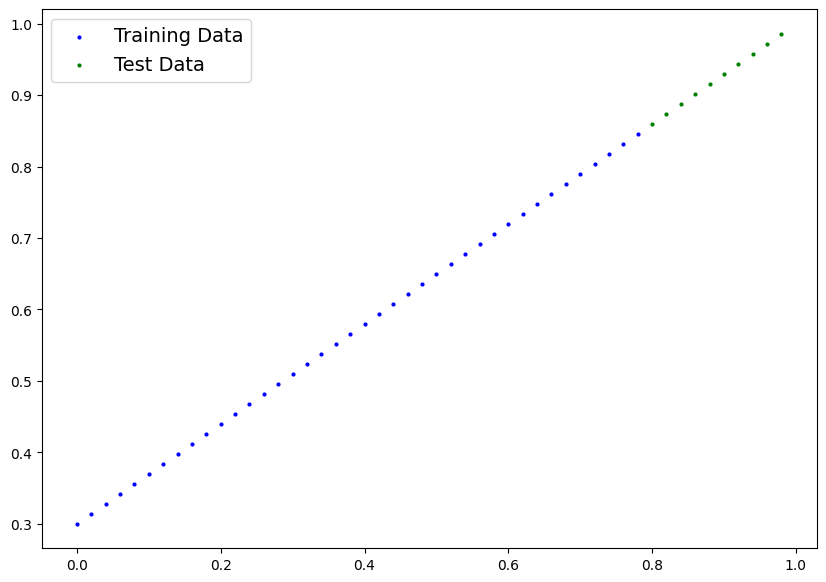

In [8]:
plot_predictions(X_train, y_train)

*** Building model

In [9]:
#Create a liner model by subclassing nn.Module
class LinerRegressinModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    # Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

    #self.weights = nn.Parameters(torch.randn (1,
    #                                         requires_grad=True,
    #                                         dtype=torch.float))
    #self.bias = nn.Parameters(torch.randn (1,
    #                                         requires_grad=True,
    #                                         dtype=torch.float))

  def forward(self, x: torch.Tensor)-> torch.Tensor:
    return self.linear_layer(x)

# Set the manual seed
torch.manual_seed(42)
model_1 = LinerRegressinModelV2()
model_1, model_1.state_dict()

(LinerRegressinModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [10]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [11]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [12]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

*** Training
* Loss function
* Optimizer
* Training loop
* Test loop

In [13]:
# Setup loss function
loss_fn = nn.L1Loss() #same as MAE

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),lr=0.01) #graduate decend

# Training loop
torch.manual_seed(42)

epochs = 100

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optmizer Step
  optimizer.step()

  ### Testing
  model_1.eval() # Set the module in evaluation mode.
  with torch.inference_mode():
    test_pred = model_1(X_test)
    test_loss = loss_fn(test_pred, y_test)

  # Print out current status

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")


Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.04784906655550003
Epoch: 60 | Loss: 0.0199567973613739 | Test loss: 0.04580312222242355
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.0375305712223053
Epoch: 80 | Loss: 0.013089170679450035 | Test loss: 0.029944902285933495
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703


In [14]:
# Checking
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6691]])),
             ('linear_layer.bias', tensor([0.3130]))])

*** Making and evalation plot_predictions

In [15]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)



In [16]:
y_preds

tensor([[0.8483],
        [0.8617],
        [0.8750],
        [0.8884],
        [0.9018],
        [0.9152],
        [0.9286],
        [0.9420],
        [0.9553],
        [0.9687]])

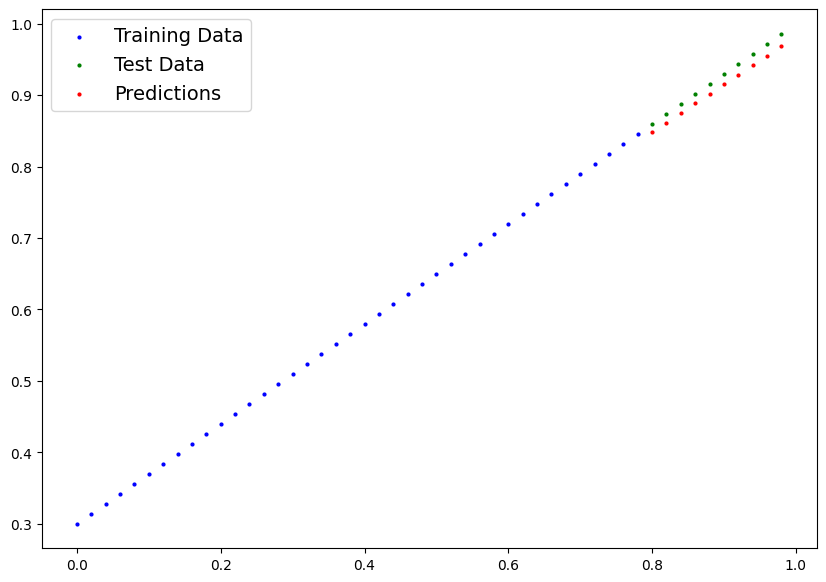

In [17]:
# Check out model predictions visually
plot_predictions(predictions=y_preds.cpu())

Saving and loading a model

In [18]:
from pathlib import Path

In [19]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME= "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

In [20]:
MODEL_SAVE_PATH

PosixPath('models/01_pytorch_workflow_model_1.pth')

In [21]:
# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")

torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_1.pth


In [22]:
# Load a PyTorch model
loaded_model_1 = LinerRegressinModelV2